In [94]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pymongo

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score
from sklearn import metrics



In [95]:
client = pymongo.MongoClient('mongo', 27017)

# Database Name conection
db = client["movies_database"]

# Collection Name
col = db["data"]
x = col.find()

df =  pd.DataFrame(list(x))

In [96]:
#df = pd.read_csv('movies_with_sentiment_analysis.csv')

In [97]:
df_results = pd.DataFrame(columns=['algorithm_name', 'score', 'target'])

In [98]:
df.head(10)

,id,movie_title,twitter_neg,twitter_pos,twitter_neu,gross_total,max_theaters,opening_weekend_gross,release_date,score,...,genre_horror,genre_kids,genre_musical,genre_mystery,genre_romance,genre_sci-fi,genre_tv_series,genre_thriller,genre_war,genre_western
0,0,The Avengers,6.0,95.0,3843.0,623357910,4349,207438708,2012/05/4,3.0,...,0,0,0,0,0,1,0,0,0,0
1,1,The Dark Knight Rises,2.0,9.0,2951.0,448139099,4404,160887295,2012/07/20,7.5,...,0,0,0,0,0,0,0,1,0,0
2,2,The Hunger Games,94.0,57.0,4261.0,408010692,4137,152535747,2012/03/23,6.2,...,0,0,0,0,0,1,0,1,0,0
3,3,Skyfall,4.0,61.0,1428.0,304360277,3526,88364714,2012/11/9,6.6,...,0,0,0,0,0,0,0,1,0,0
4,4,The Hobbit: An Unexpected Journey,0.0,3.0,1472.0,303003568,4100,84617303,2012/12/14,7.0,...,0,0,0,0,0,0,0,0,0,0
5,5,The Amazing Spider-Man,0.0,141.0,1337.0,262030663,4318,62004688,2012/07/3,5.8,...,0,0,0,0,1,0,0,0,0,0
6,6,Brave,8.0,156.0,1330.0,237283207,4164,66323594,2012/06/22,6.5,...,0,0,0,0,0,0,0,0,0,0
7,7,Ted,49.0,135.0,2792.0,218815487,3303,54415205,2012/06/29,5.5,...,0,0,0,0,0,0,0,0,0,0
8,8,Madagascar 3: Europe's Most Wanted,0.0,5.0,1484.0,216391482,4263,60316738,2012/06/8,5.8,...,0,1,0,0,0,0,0,0,0,0
9,9,Wreck-It Ralph,0.0,13.0,1475.0,189422889,3752,49038712,2012/11/2,6.9,...,0,0,0,0,0,0,0,0,0,0


# Pre-analysis

In [56]:
original_df = df
final_df=original_df
df = df.drop(columns=['release_date', 'movie_title', 'id'], axis=0)

## Differents values

In [57]:
df['max_theaters'].describe()

count     947.000000
mean     2818.786695
std       971.671773
min       600.000000
25%      2233.000000
50%      3003.000000
75%      3517.000000
max      4802.000000
Name: max_theaters, dtype: float64

In [58]:
df['score'].describe()

count    947.000000
mean       5.605385
std        0.981683
min        2.500000
25%        4.900000
50%        5.600000
75%        6.300000
max        8.500000
Name: score, dtype: float64

In [59]:
df['running_time_min'].describe()

count    947.000000
mean     109.280887
std       19.235364
min        4.000000
25%       96.000000
50%      107.000000
75%      121.000000
max      207.000000
Name: running_time_min, dtype: float64

In [60]:
for col in df.columns.to_list():
  if col.startswith('genre_'):
    print(f'{col}: {df[col].value_counts()[1]}/{len(df)}')

genre_action: 251/947
genre_adventure: 144/947
genre_animation: 83/947
genre_comedy: 330/947
genre_documentary: 6/947
genre_drama: 325/947
genre_fantasy: 150/947
genre_film_noir: 5/947
genre_horror: 107/947
genre_kids: 28/947
genre_musical: 20/947
genre_mystery: 46/947
genre_romance: 95/947
genre_sci-fi: 139/947
genre_tv_series: 3/947
genre_thriller: 215/947
genre_war: 22/947
genre_western: 9/947


## Outliers

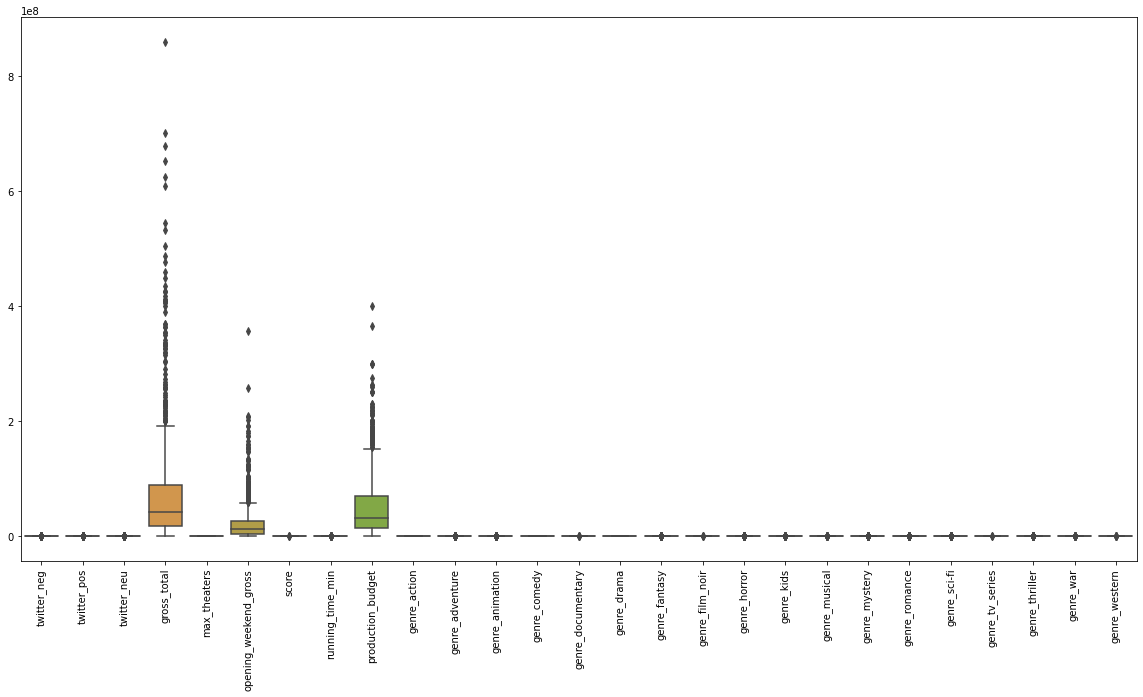

In [61]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=df)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Correlation

In [100]:
df.head(50)

,id,movie_title,twitter_neg,twitter_pos,twitter_neu,gross_total,max_theaters,opening_weekend_gross,release_date,score,...,genre_horror,genre_kids,genre_musical,genre_mystery,genre_romance,genre_sci-fi,genre_tv_series,genre_thriller,genre_war,genre_western
0,0,The Avengers,6.0,95.0,3843.0,623357910,4349,207438708,2012/05/4,3.0,...,0,0,0,0,0,1,0,0,0,0
1,1,The Dark Knight Rises,2.0,9.0,2951.0,448139099,4404,160887295,2012/07/20,7.5,...,0,0,0,0,0,0,0,1,0,0
2,2,The Hunger Games,94.0,57.0,4261.0,408010692,4137,152535747,2012/03/23,6.2,...,0,0,0,0,0,1,0,1,0,0
3,3,Skyfall,4.0,61.0,1428.0,304360277,3526,88364714,2012/11/9,6.6,...,0,0,0,0,0,0,0,1,0,0
4,4,The Hobbit: An Unexpected Journey,0.0,3.0,1472.0,303003568,4100,84617303,2012/12/14,7.0,...,0,0,0,0,0,0,0,0,0,0
5,5,The Amazing Spider-Man,0.0,141.0,1337.0,262030663,4318,62004688,2012/07/3,5.8,...,0,0,0,0,1,0,0,0,0,0
6,6,Brave,8.0,156.0,1330.0,237283207,4164,66323594,2012/06/22,6.5,...,0,0,0,0,0,0,0,0,0,0
7,7,Ted,49.0,135.0,2792.0,218815487,3303,54415205,2012/06/29,5.5,...,0,0,0,0,0,0,0,0,0,0
8,8,Madagascar 3: Europe's Most Wanted,0.0,5.0,1484.0,216391482,4263,60316738,2012/06/8,5.8,...,0,1,0,0,0,0,0,0,0,0
9,9,Wreck-It Ralph,0.0,13.0,1475.0,189422889,3752,49038712,2012/11/2,6.9,...,0,0,0,0,0,0,0,0,0,0


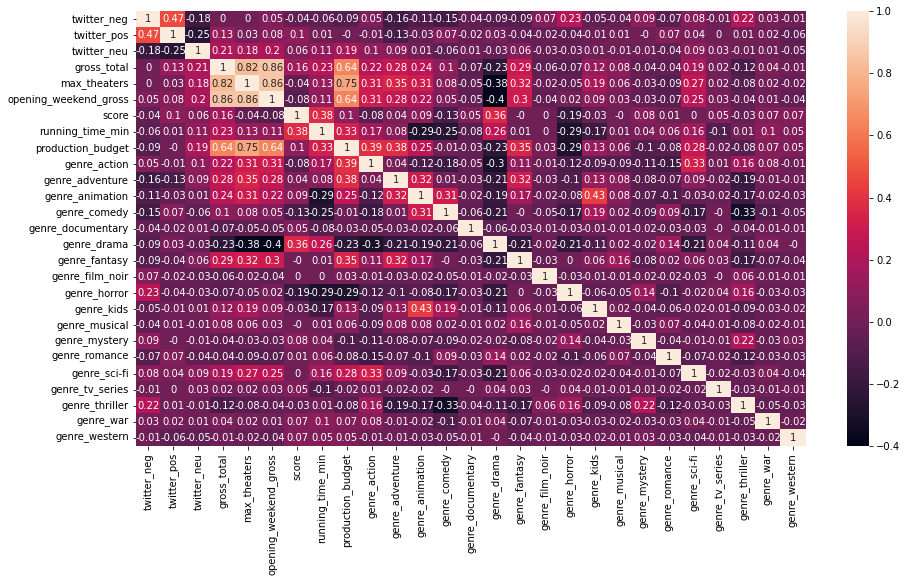

In [63]:
plt.figure(figsize=(15, 8))
sns.heatmap(round(df.corr(method='spearman'), 2), annot=True, mask=None)
plt.show()

# Models

1. Predict Score (without total gross)
2. Total gross (without score)
3. Opening weekend gross (without total gross and score)

In [64]:
def prediccion(y_test,y_pred):
  validos=0
  no_validos=0
  for i in range(len(y_pred)):
    if y_test.iloc[i]==y_pred[i].astype(int):
      validos=validos+1
    else:
      no_validos=no_validos+1
  return(print("Validos: ",validos," / No validos: ",no_validos))

## 1. Predict Score

In [65]:
notas=["Bad/<6","Good/6-7","Very Good/7-8","Excelent/+8"]
df_classification = df

In [66]:
df_classification.loc[df_classification["score"] < 4.8, "score"] = 0
df_classification.loc[(df_classification["score"] >=4.8) & (df_classification["score"] < 5.5), "score"] = 1
df_classification.loc[(df_classification["score"] >=5.5) & (df_classification["score"] < 6.3), "score"] = 2
df_classification.loc[(df_classification["score"] >=6.3), "score"] = 3

In [67]:
final_df.loc[final_df["score"] < 4.8, "score"] = 0
final_df.loc[(final_df["score"] >=4.8) & (final_df["score"] < 5.5), "score"] = 1
final_df.loc[(final_df["score"] >=5.5) & (final_df["score"] < 6.3), "score"] = 2
final_df.loc[(final_df["score"] >=6.3), "score"] = 3

In [68]:
y=df_classification["score"]
cols = list(df_classification.columns)
scaler = MinMaxScaler()

df_classification = scaler.fit_transform(df_classification)
df_classification = pd.DataFrame(df_classification, columns=cols)

In [69]:
df_classification = df_classification.drop(columns=['score', 'gross_total'])
X = df_classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfc = RandomForestClassifier(n_estimators=2000,criterion="gini")
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
score = rfc.score(X_test, y_test)
print(score)
df_results = df_results.append({'algorithm_name':'random_forest_classifier', 'score': score, 'target': 'score'}, ignore_index=True)
y_pred_df=rfc.predict(X)


0.4789473684210526


In [70]:
final_df.insert(6,'predicted_score', y_pred_df)


In [71]:
final_df["score"]=final_df["score"].astype(int)
final_df["predicted_score"]=final_df["predicted_score"].astype(int)

In [72]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, annot=True, fmt="d");
    plt.title("Matriz de confusión")
    plt.ylabel('Realidad')
    plt.xlabel('Predicción')
    plt.show()
    print()
    print(classification_report(y_test, pred_y))

Accuracy: 0.4789473684210526
Validos:  91  / No validos:  99


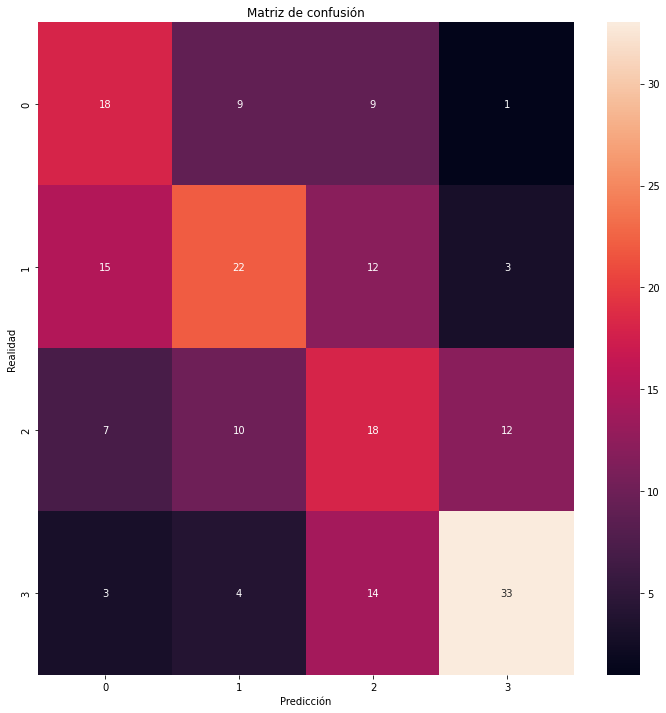


              precision    recall  f1-score   support

         0.0       0.42      0.49      0.45        37
         1.0       0.49      0.42      0.45        52
         2.0       0.34      0.38      0.36        47
         3.0       0.67      0.61      0.64        54

    accuracy                           0.48       190
   macro avg       0.48      0.48      0.48       190
weighted avg       0.49      0.48      0.48       190



In [73]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rfc))
prediccion(y_test,y_pred_rfc)
mostrar_resultados(y_test,y_pred_rfc)

## 2. Gross total (Linear Regression)

In [74]:
cols = list(df.columns)
scaler = MinMaxScaler()
scaler_y = MinMaxScaler()


df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=cols)

df_y = scaler_y.fit_transform(pd.DataFrame(original_df["gross_total"].values.tolist(),columns=["gross_total"]))
y = pd.DataFrame(df_y, columns=["gross_total"])

df_regresion = df.drop(columns=['score', 'gross_total', 'max_theaters'])

X = df_regresion

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [76]:
score = model.score(X_test, y_test)
print(score)

0.8319824854132134


In [77]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'linear_regression', 'score': r2, 'target': 'gross_total'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'gross_total', 'predicted_gross_total'])
results['movie_title']=original_df['movie_title']
results['gross_total']=original_df['gross_total']
results['predicted_gross_total']=model.predict(X)

results.head()

,movie_title,gross_total,predicted_gross_total
0,The Avengers,623357910,0.659042
1,The Dark Knight Rises,448139099,0.555160
2,The Hunger Games,408010692,0.498811
3,Skyfall,304360277,0.300567
4,The Hobbit: An Unexpected Journey,303003568,0.300333


In [78]:
y_pred_transformed=model.predict(X)
y_pred_reversed=scaler_y.inverse_transform(y_pred_transformed)
y_pred_reversed
df_scaled=pd.DataFrame(y_pred_reversed,columns=["predicted_gross_total"])

final_df.insert(2,'predicted_gross_total', y_pred_reversed)
final_df["predicted_gross_total"]=final_df["predicted_gross_total"].astype(int)

## 3. Opening weekend gross (Random Forest Regressor)

In [79]:
cols = list(df.columns)
del scaler_y
del scaler
scaler = MinMaxScaler()
scaler_y = MinMaxScaler()


df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=cols)

df_y = scaler_y.fit_transform(pd.DataFrame(original_df["opening_weekend_gross"].values.tolist(),columns=["opening_weekend_gross"]))
y = pd.DataFrame(df_y, columns=["opening_weekend_gross"])

df_regresion= df.drop(columns=['opening_weekend_gross','score', 'gross_total'])

X = df_regresion

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=700) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [81]:
score = model.score(X_test, y_test)
print(score)

0.7170378096601021


In [82]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
df_results = df_results.append({'algorithm_name':'random_forest_regressor', 'score': r2, 'target': 'opening_weekend_gross'}, ignore_index=True)

results = pd.DataFrame(columns=['movie_title', 'opening_weekend_gross', 'predicted_opening_weekend_gross'])
results['movie_title']=original_df['movie_title']
results['opening_weekend_gross']=original_df['opening_weekend_gross']
results['predicted_opening_weekend_gross']=model.predict(X)

results.head()

,movie_title,opening_weekend_gross,predicted_opening_weekend_gross
0,The Avengers,207438708,0.535191
1,The Dark Knight Rises,160887295,0.468418
2,The Hunger Games,152535747,0.401596
3,Skyfall,88364714,0.190442
4,The Hobbit: An Unexpected Journey,84617303,0.223178


In [83]:
y_pred_transformed=model.predict(X)
y_pred_transformed

array([5.35191188e-01, 4.68417711e-01, 4.01596484e-01, 1.90441873e-01,
       2.23178266e-01, 2.28998254e-01, 2.33217298e-01, 1.25224674e-01,
       1.83348206e-01, 1.24468354e-01, 8.70911869e-03, 1.97707200e-01,
       6.28216265e-02, 1.46433716e-01, 6.21207259e-02, 9.56520018e-02,
       1.44343416e-01, 8.13685862e-02, 5.78123519e-02, 1.48423666e-02,
       1.13575173e-01, 5.11202295e-02, 8.98388581e-02, 1.17113122e-01,
       7.29847808e-02, 6.82999043e-02, 4.87373679e-02, 7.73428002e-02,
       7.16956357e-02, 7.21254807e-02, 7.61783212e-02, 7.94223283e-02,
       9.63532526e-02, 4.89307808e-02, 1.14411989e-01, 6.08577610e-02,
       3.21016928e-02, 5.41196797e-02, 4.93030055e-02, 1.42903352e-01,
       2.48773008e-02, 5.79664338e-02, 5.48125217e-02, 4.24808195e-02,
       4.73827942e-02, 5.57592995e-02, 4.54240510e-02, 7.29549219e-02,
       5.70665242e-02, 6.00209804e-02, 5.43908224e-02, 6.42563615e-02,
       5.24873398e-02, 8.20070742e-02, 7.44150715e-02, 2.62808599e-02,
      

In [84]:
y_pred_reversed=scaler_y.inverse_transform(y_pred_transformed.reshape(1,-1))
y_pred_reversed

array([[1.91135425e+08, 1.67291140e+08, 1.43429804e+08, 6.80281484e+07,
        7.97180575e+07, 8.17963296e+07, 8.33029172e+07, 4.47395980e+07,
        6.54950556e+07, 4.44695220e+07, 3.13280699e+06, 7.06225396e+07,
        2.24559592e+07, 5.23131807e+07, 2.22056731e+07, 3.41794287e+07,
        5.15667509e+07, 2.90789330e+07, 2.06671865e+07, 5.32294170e+06,
        4.05796525e+07, 1.82774821e+07, 3.21036007e+07, 4.18430264e+07,
        2.60851419e+07, 2.44122092e+07, 1.74265809e+07, 2.76413564e+07,
        2.56247983e+07, 2.57782925e+07, 2.72255301e+07, 2.83839396e+07,
        3.44298399e+07, 1.74956471e+07, 4.08784729e+07, 2.17546782e+07,
        1.14861118e+07, 1.93485622e+07, 1.76285656e+07, 5.10525153e+07,
        8.90633804e+06, 2.07222079e+07, 1.95959706e+07, 1.51924165e+07,
        1.69428732e+07, 1.99340576e+07, 1.62434214e+07, 2.60744795e+07,
        2.04008573e+07, 2.14558704e+07, 1.94453852e+07, 2.29682918e+07,
        1.87656664e+07, 2.93069321e+07, 2.65958875e+07, 9.407537

In [85]:
y_pred_reversed=y_pred_reversed.reshape(-1,1)

In [86]:
df_scaled=pd.DataFrame(y_pred_reversed,columns=["predicted_opening_weekend_gross"])

final_df.insert(5,'predicted_opening_weekend_gross', y_pred_reversed)
final_df["predicted_opening_weekend_gross"]=final_df["predicted_opening_weekend_gross"].astype(int)

In [87]:
final_df

,id,movie_title,predicted_gross_total,twitter_neg,twitter_pos,predicted_opening_weekend_gross,twitter_neu,gross_total,predicted_score,max_theaters,...,genre_horror,genre_kids,genre_musical,genre_mystery,genre_romance,genre_sci-fi,genre_tv_series,genre_thriller,genre_war,genre_western
0,0,The Avengers,565854223,6.0,95.0,191135425,3843.0,623357910,0,4349,...,0,0,0,0,0,1,0,0,0,0
1,1,The Dark Knight Rises,476730337,2.0,9.0,167291140,2951.0,448139099,3,4404,...,0,0,0,0,0,0,0,1,0,0
2,2,The Hunger Games,428386968,94.0,57.0,143429804,4261.0,408010692,2,4137,...,0,0,0,0,0,1,0,1,0,0
3,3,Skyfall,258307614,4.0,61.0,68028148,1428.0,304360277,3,3526,...,0,0,0,0,0,0,0,1,0,0
4,4,The Hobbit: An Unexpected Journey,258106558,0.0,3.0,79718057,1472.0,303003568,3,4100,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,942,Brian Banks,14059333,2.0,9.0,803113,1352.0,4376819,3,1240,...,0,0,0,0,0,0,0,0,0,0
943,943,Replicas,1267107,1.0,10.0,3292896,1436.0,4046429,0,2329,...,0,0,0,0,0,1,0,1,0,0
944,944,The Beach Bum,10776397,0.0,19.0,739958,1422.0,3502600,0,1100,...,0,0,0,0,0,0,0,0,0,0
945,945,El Chicano,6519293,0.0,2.0,443891,657.0,1400603,2,605,...,0,0,0,0,0,0,0,0,0,0


# Results

In [88]:
df_results['score'] = df_results['score']*100
df_results = df_results.sort_values(by=['score'], ascending=False)

df_score = df_results.loc[df_results['target'] == 'score']
df_gross_total = df_results.loc[df_results['target'] == 'gross_total']
df_opening_weekend_gross = df_results.loc[df_results['target'] == 'opening_weekend_gross']

In [89]:
df_results = df_results.sort_values(by=['score'])

In [90]:
df_final_results = df_score.head(1)
df_final_results = df_final_results.append(df_gross_total.head(1))
df_final_results = df_final_results.append(df_opening_weekend_gross.head(1))

## Final conclusion

In [91]:
df_final_results

,algorithm_name,score,target
0,random_forest_classifier,47.894737,score
1,linear_regression,83.198249,gross_total
2,random_forest_regressor,71.703781,opening_weekend_gross


In [ ]:
df_final_results.to_csv("accuracy_predictions_ML-NLP.csv",index=0,columns=df_final_results.columns.values.tolist())

In [92]:
final_df.to_csv("movies_list_2012-2020_predictions_ML-NLP.csv",index=0,columns=final_df.columns.values.tolist())